# Download UrbanSound8K Dataset from Kaggle using Opendatasets

In [ ]:
from google.colab import files

print(f"{'*'*27}\n* Upload Kaggle.json file *\n{'*'*27}")
kaggle_json = files.upload()

***************************
* Upload Kaggle.json file *
***************************


Saving kaggle.json to kaggle (1).json


In [ ]:
%%capture
!pip install opendatasets

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/chrisfilo/urbansound8k'
od.download(dataset_url)

Skipping, found downloaded files in "./urbansound8k" (use force=True to force download)


# Import Necessary Libraries

In [ ]:
%%capture
!pip install librosa

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import librosa
import librosa.display
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

# EDA

In [ ]:
all_audio_files = glob.glob("/content/urbansound8k/*/*.wav")
print(f"Total Audio Files: {len(all_audio_files)}")
print(f"Sampel file: {all_audio_files[0]}")

Total Audio Files: 8732
Sampel file: /content/urbansound8k/fold8/55013-3-0-1.wav


In [ ]:
filename = all_audio_files[0]
data, sample_rate=librosa.load(filename)
print(f"data shape: {data.shape}\ndata sample: {data[:3]}...")
print(f"sample rate: {sample_rate}")
ipd.Audio(filename)

data shape: (88200,)
data sample: [0.00230569 0.00319139 0.00233925]...
sample rate: 22050


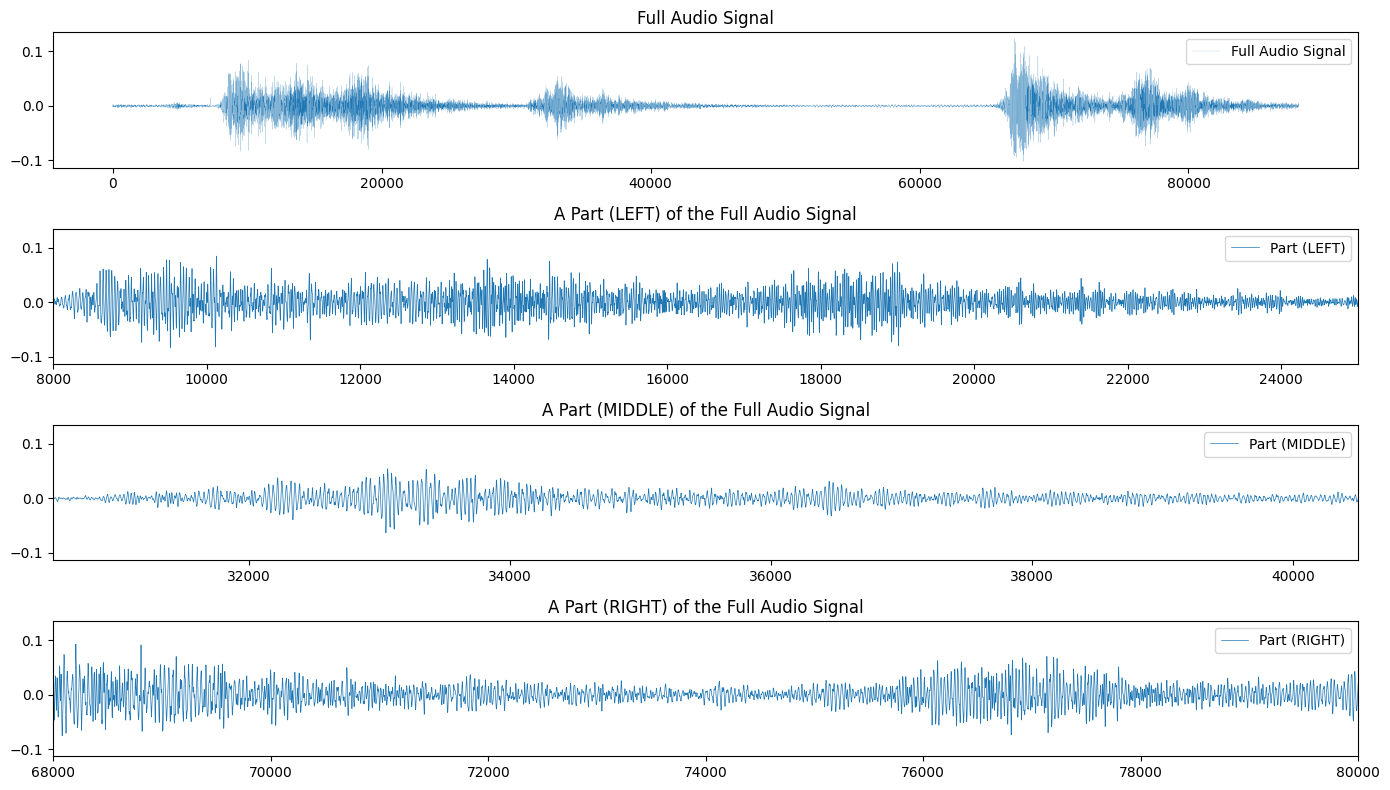

In [ ]:
# Plot the first subplot
plt.subplot(4, 1, 1)
pd.Series(data).plot(figsize=(14,8), lw=0.1, label='Full Audio Signal')
plt.title('Full Audio Signal')
plt.legend()

# Plot the second subplot
plt.subplot(4, 1, 2)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (LEFT)')
plt.xlim(8000, 25000)
plt.title('A Part (LEFT) of the Full Audio Signal')
plt.legend()

# Plot the third subplot
plt.subplot(4, 1, 3)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (MIDDLE)')
plt.xlim(30500, 40500)
plt.title('A Part (MIDDLE) of the Full Audio Signal')
plt.legend()

# Plot the fourth subplot
plt.subplot(4, 1, 4)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (RIGHT)')
plt.xlim(68000, 80000)
plt.title('A Part (RIGHT) of the Full Audio Signal')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined figure
plt.show()

In [ ]:
metadata = pd.read_csv('/content/urbansound8k/UrbanSound8K.csv')
metadata.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
7489,72221-3-1-0.wav,72221,66.415842,70.415842,2,8,3,dog_bark
7727,74364-8-1-22.wav,74364,150.037960,154.037960,2,10,8,siren
1309,132073-1-2-0.wav,132073,4.416450,4.782310,2,2,1,car_horn
3920,177729-0-0-20.wav,177729,10.000000,14.000000,2,7,0,air_conditioner
7770,74507-0-0-6.wav,74507,3.000000,7.000000,1,2,0,air_conditioner


In [ ]:
file_paths = []
for idx in tqdm(range(len(metadata))):
    # "/content/urbansound8k/fold" + str(fold) + "/" + slice_file_name
    slice_file_name = metadata.iloc[idx, 0]
    fold = metadata.iloc[idx, 5]
    full_path = "/content/urbansound8k/fold" + str(fold) + "/" + slice_file_name
    file_paths.append(full_path)

metadata['full_path'] = file_paths
metadata.sample(5)

100%|██████████| 8732/8732 [00:00<00:00, 10966.74it/s]


,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path
3680,17578-5-0-24.wav,17578,12.000000,16.000000,1,5,5,engine_idling,/content/urbansound8k/fold5/17578-5-0-24.wav
3686,17578-5-0-3.wav,17578,1.500000,5.500000,1,5,5,engine_idling,/content/urbansound8k/fold5/17578-5-0-3.wav
4086,178686-0-0-39.wav,178686,19.500000,23.500000,2,5,0,air_conditioner,/content/urbansound8k/fold5/178686-0-0-39.wav
3363,169044-2-0-3.wav,169044,1.500000,5.500000,1,3,2,children_playing,/content/urbansound8k/fold3/169044-2-0-3.wav
3111,165166-8-0-3.wav,165166,2.333454,6.333454,1,10,8,siren,/content/urbansound8k/fold10/165166-8-0-3.wav


In [ ]:
# play the audio of a random file
_idx = random.randint(0, len(metadata))
filename = metadata.iloc[_idx, -1]
data, sample_rate=librosa.load(filename)
print(f"data shape: {data.shape}\ndata sample: {data[:3]}...")
print(f"sample rate: {sample_rate}")
print(f"class: {metadata.iloc[_idx, -2]}")
ipd.Audio(filename)

data shape: (13816,)
data sample: [-0.00102672  0.00050007  0.00091522]...
sample rate: 22050
class: dog_bark


In [ ]:
### Check whether the dataset is imbalanced
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

# Feature Extraction Using MFCC

In [ ]:
def feature_extractor(file):
    raw_audio, sample_rate = librosa.load(file)
    # raw_audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=raw_audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [ ]:
metadata['mfcc_feature'] = metadata['full_path'].apply(feature_extractor)
metadata.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path,mfcc_feature
5235,201988-5-0-9.wav,201988,6.171607,10.171607,1,7,5,engine_idling,/content/urbansound8k/fold7/201988-5-0-9.wav,"[-265.92218, 89.14327, 27.364128, 43.638844, -..."
3824,177537-7-0-5.wav,177537,2.500000,6.500000,2,7,7,jackhammer,/content/urbansound8k/fold7/177537-7-0-5.wav,"[-122.66555, 113.43743, 9.427619, 16.454641, -..."
4087,178686-0-0-42.wav,178686,21.000000,25.000000,2,5,0,air_conditioner,/content/urbansound8k/fold5/178686-0-0-42.wav,"[-438.43488, 186.8182, -4.1366544, 7.460717, 1..."
1016,123685-5-0-1.wav,123685,4.345506,8.345506,1,7,5,engine_idling,/content/urbansound8k/fold7/123685-5-0-1.wav,"[-168.73874, 90.70983, 52.30112, 21.829256, 12..."
7561,72259-1-9-5.wav,72259,226.938833,230.938833,2,5,1,car_horn,/content/urbansound8k/fold5/72259-1-9-5.wav,"[-119.394104, 105.38261, -45.286884, 32.441654..."


In [ ]:
extracted_features = metadata.iloc[:, [-1, -3]]
extracted_features

,mfcc_feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.3139, -44.84709, 24.968985, -...",car_horn


In [ ]:
X = np.array(extracted_features['mfcc_feature'].tolist())
y = np.array(extracted_features['class'].tolist())

X.shape, y.shape

((8732, 40), (8732,))

In [ ]:
y = np.array(pd.get_dummies(y))
y.shape

(8732, 10)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6985, 40), (1747, 40), (6985, 10), (1747, 10))

# ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
num_labels = y.shape[1]

In [ ]:
model = Sequential([
    # First layer
    Dense(100, input_shape=(X_train.shape[1],)), # (40, )
    Activation('relu'),
    Dropout(0.5),

    # Second layer
    Dense(200),
    Activation('relu'),
    Dropout(0.5),

    # Third layer
    Dense(100),
    Activation('relu'),
    Dropout(0.5),

    # Output layer
    Dense(num_labels),
    Activation('softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               2

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/ann.hdf5',
                               verbose=1,
                               save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train,
          batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpointer], verbose=1
        )

duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
print(test_accuracy[1])

0.7744705080986023


In [ ]:
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path,mfcc_feature
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,/content/urbansound8k/fold5/100032-3-0-0.wav,"[-211.93698, 62.581215, -122.813156, -60.74529..."
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,/content/urbansound8k/fold5/100263-2-0-117.wav,"[-417.0052, 99.336624, -42.995586, 51.073326, ..."
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,/content/urbansound8k/fold5/100263-2-0-121.wav,"[-452.39316, 112.36253, -37.578075, 43.195866,..."
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,/content/urbansound8k/fold5/100263-2-0-126.wav,"[-406.47922, 91.1966, -25.043556, 42.78452, 11..."
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,/content/urbansound8k/fold5/100263-2-0-137.wav,"[-439.63873, 103.86223, -42.658787, 50.690285,..."
...,...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,/content/urbansound8k/fold7/99812-1-2-0.wav,"[-391.3721, 125.36239, -40.634056, 25.899754, ..."
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,/content/urbansound8k/fold7/99812-1-3-0.wav,"[-339.42715, 76.409096, -35.30988, 41.984035, ..."
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,/content/urbansound8k/fold7/99812-1-4-0.wav,"[-297.31534, 102.09026, -36.75108, 26.816488, ..."
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,/content/urbansound8k/fold7/99812-1-5-0.wav,"[-336.92386, 115.3139, -44.84709, 24.968985, -..."


# Test the Model

In [ ]:
# testing random samples
_idx = random.randint(0, len(metadata))
filename = metadata.iloc[_idx, -2]
# mfccs_scaled_features = feature_extractor(filename)
mfccs_scaled_features = metadata.iloc[_idx, -1].reshape(1,-1)
class_idx = metadata.iloc[_idx, -4]
predicted_label = model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_label)

print(f"   Actual label: {class_idx} -> {metadata.loc[metadata['classID'] == class_idx].iloc[0, -3]}")
print(f"Predicted label: {predicted_label} -> {metadata.loc[metadata['classID'] == predicted_label].iloc[0, -3]}")

ipd.Audio(filename)

1/1 [==============================] - 0s 22ms/step
   Actual label: 1 -> car_horn
Predicted label: 1 -> car_horn
